### Kaggle datasets: IMDB movie ratings analysis

In [1]:
from __future__ import division
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Disable pandas SettingWithCopyWarning
pd.options.mode.chained_assignment = None

work_dir = os.environ['WORK_DIR']

# Load data (movie_metadata.csv downloaded from https://www.kaggle.com/deepmatrix/imdb-5000-movie-dataset)
df = pd.read_csv(os.path.join(work_dir, 'movie_metadata.csv'))
df.head()


,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
4,NaN,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,7.1,NaN,0


In [2]:
### SHARE OF MISSING DATA PER ATTRIBUTE ###

missing = df[df.isnull().any(axis=1)].count().to_frame()
missing.columns = ['missing']
total = df.count().to_frame()
total.columns = ['total']

share_of_missing = missing.join(total)
share_of_missing.share = share_of_missing.missing / share_of_missing.total
share_of_missing.head()

,missing,total
color,1268,5024
director_name,1183,4939
num_critic_for_reviews,1237,4993
duration,1272,5028
director_facebook_likes,1183,4939


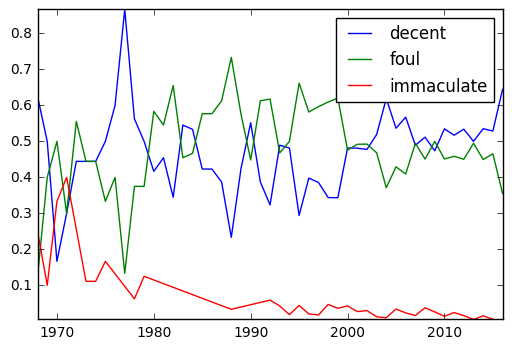

In [3]:
### CONTENT RATINGS TIME SERIES ###

# Prepare subset of the data

labels = ['content_rating', 'title_year']
# print share_of_missing.loc[labels]

ts = df[labels]
ts = ts[pd.notnull(ts.title_year) & pd.notnull(ts.content_rating)]
ts.title_year = ts.title_year.astype(int)


# Get distinct content rating values

# print ts.content_rating.unique()

ratings = ts[labels].groupby('title_year')['content_rating'].unique

# print ratings.head(10)
# print ratings.tail(10)


# Map content ratings from different periods 
# https://en.wikipedia.org/wiki/Motion_Picture_Association_of_America_film_rating_system

ts = ts[ts.title_year >= 1968]

def map_ratings(row):
    immaculate = ['G', 'TV-G']
    decent = ['PG', 'GP', 'PG-13', 'M']
    foul = ['R', 'NC-17', 'X']
    
    if row.content_rating in immaculate:
        return 'immaculate'
    if row.content_rating in decent:
        return 'decent'
    if row.content_rating in foul:
        return 'foul'

ts['rating_map'] = ts.apply(map_ratings, axis=1)


# Check how the share of immaculate, decent and foul movies changed over time

ts = ts.groupby(['title_year', 'rating_map']).count().reset_index()
ts['yearly_total'] = ts.groupby('title_year')['content_rating'].transform('sum')
ts['rating_share'] = ts.content_rating / ts.yearly_total


# Plot the time series

ratings = ts['rating_map'].unique()

for rating in ts['rating_map'].unique():
    sub_ts = ts[ts.rating_map == rating]
    plt.plot(sub_ts['title_year'], sub_ts['rating_share'])
axes = plt.gca()
axes.set_ylim([ts.rating_share.min(), ts.rating_share.max()])
axes.set_xlim([ts.title_year.min(), ts.title_year.max()])
plt.legend(ratings)
plt.show()


In [4]:
# Comparing change in content rating share between 2000 and 2010 using Chi-square 
ratings_2000 = ts[ts.title_year == 2000][['rating_map', 'rating_share']]
ratings_2000.rename(columns={'rating_share': 'rating_share_2000'}, inplace=True)
ratings_2010 = ts[ts.title_year == 2010][['rating_map', 'content_rating', 'yearly_total']]
ratings_2010.rename(columns={'content_rating': 'rating_count_2010', 'yearly_total': 'total_2010'}, inplace=True)
chi_2_test = ratings_2000.merge(ratings_2010, on='rating_map')

# print chi_2_test.head()

# H0: the share of ratings didn't change between 2000 and 2010 
#     foul = 0.482
#     decent = 0.476
#     immaculate = 0.043 
#
# HA: the share of ratings changed between 2000 and 2010
#     foul <> 0.482 OR decent <> 0.476 OR immaculate <> 0.043

# Computing Chi-square test statistic
chi_2_test['expected_cell_count'] = chi_2_test['rating_share_2000'] * chi_2_test['total_2010']

# Check if the sample size is large enough to use chi-square distribution
small_subsets = chi_2_test[chi_2_test['expected_cell_count'] < 5]
assert small_subsets.empty

def compute_partial_chi_2(row):
    expected_count = row.total_2010 * row.rating_share_2000
    return (row.rating_count_2010 - expected_count)**2 / expected_count 

chi_2_test['partial_chi_2'] = chi_2_test.apply(compute_partial_chi_2, axis=1)
computed_chi_2 = chi_2_test['partial_chi_2'].sum()
# print computed_chi_2


# Check the boarder chi-square value from distribution with 2 degrees of freedom and 5% confidence level

tabulated_chi_2 = 10.597

# Because computed_chi_2 < tabulated_chi_2 we don't reject H0
# There is no difference in share of ratings between 2000 and 2010 


In [37]:
### GENDER VS YEARS IN BUSINESS ###

import sexmachine.detector as gender
d = gender.Detector()

# Prepare subset of data
actors = pd.DataFrame({'actor_name': [], 'year': [], 'imdb_score':[]})
for label in ['actor_1_name', 'actor_2_name', 'actor_3_name']:
    labels = [label, 'title_year', 'imdb_score']
    tmp = df[labels]
    tmp = tmp[pd.notnull(tmp['title_year']) & pd.notnull(tmp[label])]
    tmp = tmp.rename(columns={'title_year': 'year', label: 'actor_name'})
    actors = pd.concat([actors, tmp])
actors['gender'] = actors.actor_name.apply(lambda x: d.get_gender(x.split()[0]))

# print actors.gender.unique()

def map_genders(row):
    female = ['female', 'mostly_female']
    male = ['male', 'mostly_male']
    
    if row.gender == 'andy':
        return np.nan
    if row.gender in female:
        return 0
    if row.gender in male:
        return 1

actors['gender'] = actors.apply(map_genders, axis=1)
actors.dropna(inplace=True)

start_years = actors.groupby(['actor_name'])['year'].min().reset_index()
start_years = start_years.rename(columns={'year': 'start_year'})
end_years = actors.groupby(['actor_name'])['year'].max().reset_index()
end_years = end_years.rename(columns={'year': 'end_year'})

actors = actors.merge(start_years)
actors = actors.merge(end_years)

actors['years_of_work'] = actors.end_year - actors.start_year

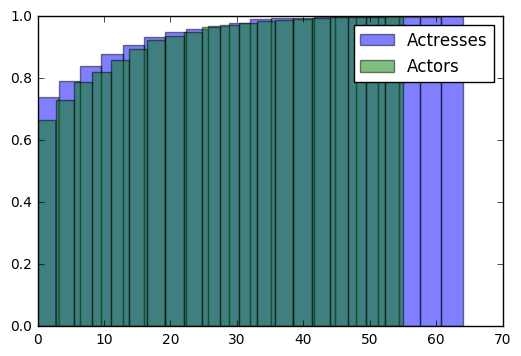

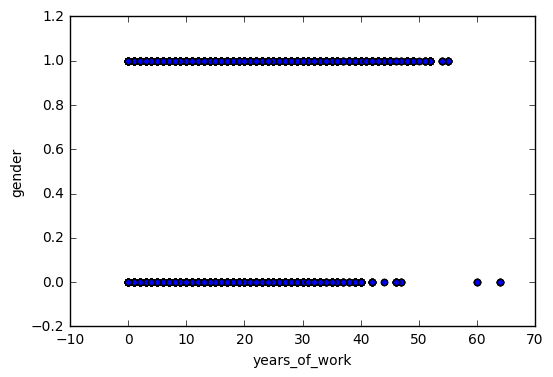

In [41]:
# Years of work distribution by gender


females = actors[actors.gender == 0]
females = females[['actor_name', 'gender', 'years_of_work']]
females.drop_duplicates(inplace=True)
males = actors[actors.gender == 1]
males = males[['actor_name', 'gender', 'years_of_work']]
males.drop_duplicates(inplace=True)

plt.hist(females['years_of_work'], 20, alpha=0.5, label='Actresses', normed=True, cumulative=True)
plt.hist(males['years_of_work'], 20, alpha=0.5, label='Actors', normed=True, cumulative=True)
plt.legend(loc='upper right')
plt.show()

actors.plot(kind='scatter', x='years_of_work', y='gender')
plt.show()

# The are more actresses than actors with very short careers.
# Women on average DO live longer, but the are more old active actors than old active actresses.

In [50]:
# Years of work before the best movie by gender

# Prepare subset of data
best_movies = actors.copy()
best_movies['best_imdb_score'] = best_movies.groupby(['actor_name'])['imdb_score'].transform(max)
best_movies = best_movies[best_movies['best_imdb_score'] == best_movies['imdb_score']]
best_movies['earlier_movie'] = best_movies.groupby(['actor_name'])['year'].transform(min)
best_movies = best_movies[best_movies['year'] == best_movies['earlier_movie']]
best_movies['years_till_best'] = best_movies['year'] - best_movies['start_year']

/home/malgorzata/Repos/kaggle/venv/lib/python2.7/site-packages/ipykernel/__main__.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


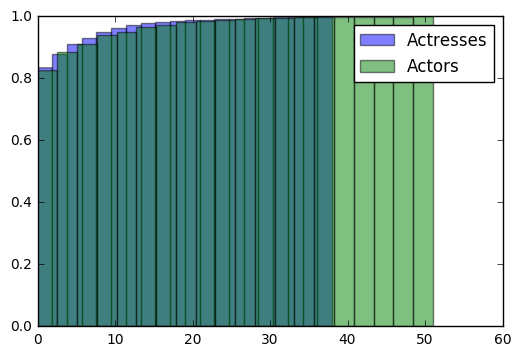

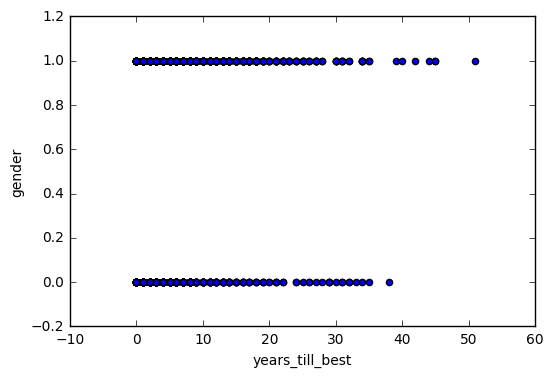

In [53]:
# Years till best distribution by gender

best_females = best_movies[best_movies.gender == 0]

best_males = best_movies[actors.gender == 1]

plt.hist(best_females['years_till_best'], 20, alpha=0.5, label='Actresses', normed=True, cumulative=True)
plt.hist(best_males['years_till_best'], 20, alpha=0.5, label='Actors', normed=True, cumulative=True)
plt.legend(loc='upper right')
plt.show()

best_movies.plot(kind='scatter', x='years_till_best', y='gender')
plt.show()

# Men get better with age.